# ST590 - Project 2

Authored by Group 13 - Dave Bergeron, Xavier Genelin, and Maksim Nikiforov

## Part 2

In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sqlite3

In [2]:
con = sqlite3.connect("northwind.sqlite")
pd.read_sql('SELECT * FROM sqlite_schema WHERE type = \'table\'', con)

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
3,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
4,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
7,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
8,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
9,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...


The _Employees_ table contains information on nine individuals whose employee identifications range of 1 to 9. One employee is a vice president, one employee is a sales manager, and six employees are sales representatives. The six representatives have access to one insides sales coordinator who presumably helps fulfill orders, ensures timely delivery, and assists with other logistics.   

In [3]:
pd.read_sql('SELECT EmployeeID, LastName, FirstName, Title FROM Employees', con)

,EmployeeID,LastName,FirstName,Title
0,1,Davolio,Nancy,Sales Representative
1,2,Fuller,Andrew,"Vice President, Sales"
2,3,Leverling,Janet,Sales Representative
3,4,Peacock,Margaret,Sales Representative
4,5,Buchanan,Steven,Sales Manager
5,6,Suyama,Michael,Sales Representative
6,7,King,Robert,Sales Representative
7,8,Callahan,Laura,Inside Sales Coordinator
8,9,Dodsworth,Anne,Sales Representative


We can assess the performance of each individual by understanding how much they sell. To do this, we can combine information from the _Orders_ table with additional details from the _Order Details_ table.  

In [4]:
# Merge "Orders" and "Order Details" tables to reveal the quantitites sold by each employee
# as well as the price and discount per unit
orders_per_employee = pd.merge(
    left = pd.read_sql("SELECT EmployeeID, OrderID, OrderDate FROM Orders", con), 
    right = pd.read_sql("SELECT OrderID, ProductID, UnitPrice, Quantity, Discount FROM [Order Details]", con),
    how = "left", 
    on = "OrderID")

# Create a new column to calculate total sales per order, inclusive of any discounts
orders_per_employee["TotalSale"] = \
(orders_per_employee["UnitPrice"]-orders_per_employee["UnitPrice"]*orders_per_employee["Discount"])*orders_per_employee["Quantity"]

# Group sales by EmployeeID and sum up total sales for each employee.
# Reset the index to allow the EmployeeID column to be merged with other tables. 
summed_sales = orders_per_employee[["EmployeeID", "Quantity", "TotalSale"]].groupby("EmployeeID").sum("TotalSale").reset_index()
summed_sales

,EmployeeID,Quantity,TotalSale
0,1,7812,192107.6045
1,2,6055,166537.7550
2,3,7852,202812.8430
3,4,9798,232890.8460
4,5,3036,68792.2825
5,6,3527,73913.1295
6,7,4654,124568.2350
7,8,5913,126862.2775
8,9,2670,77308.0665


By associating each employee ID with employee names, we see that Margaret Peacock sold the most amount of product, bringing in $\$232,890.85$ in sales (assuming a US Dollar currency). As sales representatives, Michael Suyama and Anne Dodsworth sold three times less, suggesting that there is room for improvement. 

In [5]:
# Merge EmployeeID with names and titles for better perspective
named_employee_sales = pd.merge(
    left = pd.read_sql("SELECT EmployeeID,  LastName, FirstName, Title FROM Employees", con),
    right = summed_sales, 
    how = "left", 
    on = "EmployeeID")

# Sort in descending order of total sales
named_employee_sales.sort_values(by=["TotalSale"], ascending=False)

,EmployeeID,LastName,FirstName,Title,Quantity,TotalSale
3,4,Peacock,Margaret,Sales Representative,9798,232890.8460
2,3,Leverling,Janet,Sales Representative,7852,202812.8430
0,1,Davolio,Nancy,Sales Representative,7812,192107.6045
1,2,Fuller,Andrew,"Vice President, Sales",6055,166537.7550
7,8,Callahan,Laura,Inside Sales Coordinator,5913,126862.2775
6,7,King,Robert,Sales Representative,4654,124568.2350
8,9,Dodsworth,Anne,Sales Representative,2670,77308.0665
5,6,Suyama,Michael,Sales Representative,3527,73913.1295
4,5,Buchanan,Steven,Sales Manager,3036,68792.2825


We can also assess annual sales for each employee.

In [6]:
# Convert "OrderDate" column to DateTime in pandas
orders_per_employee["OrderDate"] = pd.to_datetime(orders_per_employee["OrderDate"])

# Extract year from the "OrderDate" DateTime column and save it in a new column
orders_per_employee["OrderYear"] = orders_per_employee["OrderDate"].dt.year

# Extract date and month from the "OrderDate" DateTime column and save it in a new column
orders_per_employee["OrderYearMonth"] = orders_per_employee["OrderDate"].dt.to_period('M')

# Extract quarter from the "OrderDate" DateTime column and save it in a new column
orders_per_employee["OrderQuarter"] = orders_per_employee["OrderDate"].dt.to_period('Q')

# Sum up sales and group by EmployeeID and OrderYear, then view the result 
annual_employee_sales = orders_per_employee[["OrderYear", "TotalSale", "EmployeeID"]] \
                          .groupby(["EmployeeID", "OrderYear"]) \
                          .sum("TotalSale")

annual_employee_sales

TotalSale
EmployeeID OrderYear             
1          1996        35764.5150
           1997        93148.0775
           1998        63195.0120
2          1996        21757.0600
           1997        70444.1400
           1998        74336.5550
3          1996        18223.9600
           1997       108026.1555
           1998        76562.7275
4          1996        49945.1150
           1997       128809.7910
           1998        54135.9400
5          1996        18383.9200
           1997        30716.4675
           1998        19691.8950
6          1996        16642.6050
           1997        43126.3695
           1998        14144.1550
7          1996        15232.1600
           1997        60471.1950
           1998        48864.8800
8          1996        22240.1200
           1997        56032.6150
           1998        48589.5425
9          1996         9894.5150
           1997        26310.3925
           1998        41103.1590

For a more granular view, we can use a line chart to visualize quarterly employee sales. We can limit the chart to the top and bottom two sales representatives to minimize clutter. We see that Janet Leverling, the top seller, performed on par with Michael and Anne in 1996. However, her quarterly sales increased six-fold from $\$10,000$ in Q3 of 1997 to $\$60,000$ in Q1 of 1998. The performance of Margaret Peacock, the second best seller, remained stable within the $\$20,000$-$\$40,000$ range. Compared to Michael Suyama, Anne Dodsworth under-performed until Q1 of 1998, when her sales also experienced a spike and placed her just above Michael for total sales across 1996-1998. 

In [7]:
# Sum up sales and group by EmployeeID and OrderQuarter.
monthly_employee_sales = orders_per_employee[["OrderQuarter", "TotalSale", "EmployeeID"]] \
                          .groupby(["EmployeeID", "OrderQuarter"]) \
                          .sum("TotalSale")

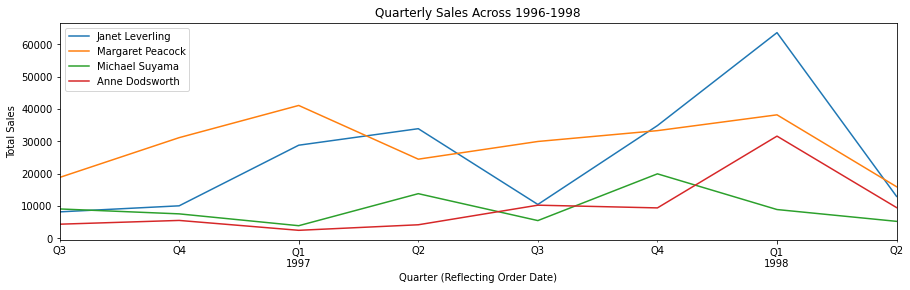

In [8]:
# Reset index to make EmployeeID and OrderQuarter columns available as columns in the data frame
monthly_sales_index_reset = monthly_employee_sales.reset_index()

# Filter result to include only the top two sellers (EmployeeID of 4 and 3)
# and the bottom two sellers (EmployeeID of 9 and 6)
top_bottom_performers = monthly_sales_index_reset[monthly_sales_index_reset["EmployeeID"].isin([4, 3, 9, 6])]

# Create a line chart. Modify the width for an expanded view. 
top_bottom_performers.set_index("OrderQuarter").groupby("EmployeeID")["TotalSale"].plot(legend=True, figsize=(15, 4))
plt.title("Quarterly Sales Across 1996-1998")
plt.ylabel("Total Sales")
plt.xlabel("Quarter (Reflecting Order Date)")
plt.legend(["Janet Leverling", "Margaret Peacock", "Michael Suyama", "Anne Dodsworth"])

Which products are being sold the most? After plotting the top ten products sold, we see that CÃ´te de Blaye (Côtes-de-Blaye?) is the most popular sales item with over $\$140,000$ sold, followed by Thüringer Rostbratwurst at just over $\$80,000$ and Raclette Courdavault at $\$71,155$.

Text(0.5, 0, 'Total Sales')

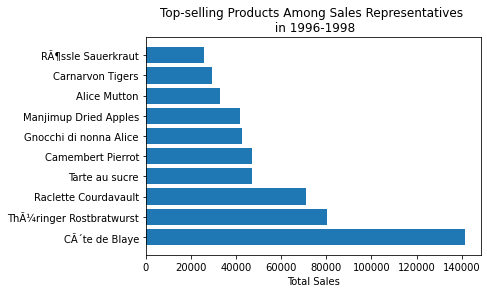

In [9]:
# Retrieve ProductID and find total sales (after grouping by ProductID and summing)
top_selling = orders_per_employee[["ProductID", "TotalSale"]] \
    .groupby("ProductID") \
    .sum("TotalSale") \
    .sort_values(by=["TotalSale"], ascending=False)

# Merge ProductID with product names for clarity (include only top 10 best-selling products)
top_selling_desc = pd.merge(
    left = top_selling,
    right = pd.read_sql("SELECT ProductID, ProductName FROM Products", con),
    how = "left", 
    on = "ProductID").head(10)

# Horizontal bar plot of top-selling products
plt.title("Top-selling Products Among Sales Representatives \n in 1996-1998")
plt.barh(y=top_selling_desc.ProductName, width=top_selling_desc.TotalSale)
plt.xlabel("Total Sales")

We can marge several data frames and tables to retrieve a data frame with more granular information for each sales representative. We see that Anne Dodsworth and Steven Buchanan both excelled at selling wine and cheese, while Nancy Davolio and Laura Callahan had success selling dried apples and pears. 

In [10]:
# Group by EmployeeID and ProductID, then sort in descending order
# based on total sales 
emp_product_sales = orders_per_employee[["EmployeeID", "ProductID", "Quantity", "TotalSale"]]\
            .groupby(["EmployeeID", "ProductID"]) \
            .sum("TotalSale") \
            .sort_values(by=["EmployeeID", "TotalSale"], ascending=False).reset_index()

# View the top 2 ProductIDs sold by each sales representatives
top_two_sold = emp_product_sales.groupby("EmployeeID").head(2)

# Supplement ProductID with ProductName and CategoryID
product_sales = pd.merge(
    left = top_two_sold,
    right = pd.read_sql("SELECT ProductID, ProductName, UnitPrice, CategoryID FROM Products", con), 
    how = "left", 
    on = "ProductID")

# Retrieve categories, descriptions
descriptive_product_sales = pd.merge(
    left = product_sales,
    right = pd.read_sql("SELECT CategoryID, CategoryName, Description FROM Categories", con), 
    how = "left", 
    on = "CategoryID")

# Retrieve sales representative names
named_product_sales = pd.merge(
    left = descriptive_product_sales,
    right = pd.read_sql("SELECT LastName, FirstName, EmployeeID FROM Employees", con), 
    how = "left", 
    on = "EmployeeID")

# Filter columns for better presentability
named_product_sales[["EmployeeID", "LastName", "FirstName", "ProductName", "Description", "CategoryName", "UnitPrice", "Quantity", "TotalSale"]]

,EmployeeID,LastName,FirstName,ProductName,Description,CategoryName,UnitPrice,Quantity,TotalSale
0,9,Dodsworth,Anne,CÃ´te de Blaye,"Soft drinks, coffees, teas, beers, and ales",Beverages,263.50,57,14624.250
1,9,Dodsworth,Anne,Raclette Courdavault,Cheeses,Dairy Products,55.00,284,14201.550
2,8,Callahan,Laura,ThÃ¼ringer Rostbratwurst,Prepared meats,Meat/Poultry,123.79,94,9244.825
3,8,Callahan,Laura,Uncle Bob's Organic Dried Pears,Dried fruit and bean curd,Produce,30.00,276,8190.000
4,7,King,Robert,CÃ´te de Blaye,"Soft drinks, coffees, teas, beers, and ales",Beverages,263.50,99,16695.360
5,7,King,Robert,ThÃ¼ringer Rostbratwurst,Prepared meats,Meat/Poultry,123.79,146,14669.115
6,6,Suyama,Michael,Raclette Courdavault,Cheeses,Dairy Products,55.00,146,6671.500
7,6,Suyama,Michael,Gnocchi di nonna Alice,"Breads, crackers, pasta, and cereal",Grains/Cereals,38.00,178,6232.000
8,5,Buchanan,Steven,Raclette Courdavault,Cheeses,Dairy Products,55.00,144,7584.500
9,5,Buchanan,Steven,CÃ´te de Blaye,"Soft drinks, coffees, teas, beers, and ales",Beverages,263.50,40,6324.000
